In [36]:
import torch
import torch.nn.functional as F
from torch import nn
from d2l import torch as d2l



In [37]:
def train_(net, train_iter, test_iter,num_epochs ,loss, updater):
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs], ylabel='loss',ylim=[0.3,0.9],legend=['train loss','train acc','text acc'])
    for epoch in range(num_epochs):
        train_metric=train_epoch(net,train_iter,loss,updater)
        test_acc=evaluate_accuracy(net,test_iter)
        animator.add(epoch+1,train_metric+(test_acc,))

def train_epoch(net, train_iter, loss,updater):
    """updater优化器，传入批量数batch，w,b为全局变量"""
    if isinstance(net, torch.nn.Module):
        net.train()
    #损失和，精度，总数
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            #内置优化器
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            #自定义优化器
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),d2l.accuracy(y_hat,y), y.numel())
    return metric[0] / metric[2],metric[1]/metric[2]

def evaluate_accuracy(net, data_iter): #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = d2l.Accumulator(2) # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(d2l.accuracy(net(X), y), y.numel())
    
    return metric[0] / metric[1]

In [44]:
batch_size=1000
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [43]:
net=nn.Sequential(nn.Flatten(),nn.Linear(28*28,10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
        nn.init.constant_(m.bias,0)
net.apply(init_weights)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

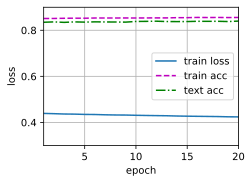

In [47]:
loss=nn.CrossEntropyLoss(reduction='none')
lr=0.1
optimizer=torch.optim.SGD(net.parameters(),lr=lr)
num_epoch=20
train_(net,train_iter,test_iter,num_epoch,loss,optimizer)
print('')